In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
path_data_science = './Q2_data_scraping/seek_data_science.csv'
path_data_analytic ='./Q2_data_scraping/seek_data_analytic.csv'

In [4]:
df_science = pd.read_csv(path_data_science)
df_analytic = pd.read_csv(path_data_analytic)

In [5]:
df_science.drop(columns = ['Unnamed: 0'], inplace = True)
df_analytic.drop(columns = ['Unnamed: 0'], inplace = True)

In [6]:
df_science.head(2)

,url,job_title,company,date,location,employment_type,field,description
0,https://www.seek.com.au/job/37458564?type=prom...,Data Analyst/Data Scientist,NaN,12 Oct 2018,Perth,Contract/Temp,Information & Communication Technology,The CompanyMSC Mediterranean shipping company ...
1,https://www.seek.com.au/job/37537274?type=stan...,"Data Developer, Data Architect, Data Science, ...",NaN,23 Oct 2018,Melbourne,Full Time,Information & Communication Technology,"Data Scientists | R, Python, SAS"


In [7]:
df_analytic.head(2)

,url,job_title,company,date,location,employment_type,field,description
0,https://www.seek.com.au/job/37356322?type=prom...,Lead Industry Analyst,NaN,1 Oct 2018,Melbourne,Full Time,Marketing & Communications,About SEEKSEEK is a diverse group of companies...
1,https://www.seek.com.au/job/37356324?type=prom...,Lead Industry Analyst,NaN,1 Oct 2018,Melbourne,Full Time,Consulting & Strategy,About SEEKSEEK is a diverse group of companies...


### Remove duplicated

In [8]:
df_analytic = df_analytic[~df_analytic.description.duplicated()]
df_science = df_science[~df_science.description.duplicated()]

In [9]:
df_analytic.shape

(1188, 8)

In [10]:
df_science.shape

(686, 8)

In [11]:
1 - 686/(1188+686)

0.6339381003201707

### Add target and combine

In [12]:
df_science['target'] = 1
df_analytic['target'] = 0

In [13]:
df = pd.concat([df_science, df_analytic], axis = 0)

### Reshuffle row

In [14]:
df = df.sample(frac = 1).reset_index(drop = True)

In [15]:
df.head(1)

,url,job_title,company,date,location,employment_type,field,description,target
0,https://www.seek.com.au/job/37403654?type=stan...,Investigative Analyst,SECMON1,7 Oct 2018,Melbourne,Full Time,Government & Defence,About the business SECMON1 is an innovative ...,0


### Clean data

In [16]:
df.isnull().sum()

url                  0
job_title            0
company            647
date                 0
location             0
employment_type      0
field                0
description          2
target               0
dtype: int64

#### remove null value

In [17]:
df = df[~df['description'].isnull()]

In [18]:
df.drop(columns = ['job_title', 'company'], inplace = True)

In [19]:
df.head(1)

,url,date,location,employment_type,field,description,target
0,https://www.seek.com.au/job/37403654?type=stan...,7 Oct 2018,Melbourne,Full Time,Government & Defence,About the business SECMON1 is an innovative ...,0


#### remove date

In [20]:
df.drop(columns = ['date'], inplace = True)

In [21]:
df.head(1)

,url,location,employment_type,field,description,target
0,https://www.seek.com.au/job/37403654?type=stan...,Melbourne,Full Time,Government & Defence,About the business SECMON1 is an innovative ...,0


In [22]:
df.employment_type.unique()

array(['Full Time', 'Contract/Temp', 'Part Time', 'Casual/Vacation'],
      dtype=object)

#### Look at location and convert to states only

In [23]:
location_list = df.location.unique().tolist()

In [24]:
from geopy.geocoders import Nominatim

In [25]:
def getAddress(value):
    try:
        geolocator = Nominatim(user_agent="specify_your_app_name_here")
        location = geolocator.geocode(str(value))

        address = location.address
    except:
        address = None
    
    return address

In [26]:
# use the geopy library to find the address of the location

geopy_translate_dict = {}
address_list = []
for location in log_progress(location_list):
    if 'Perth' in location or 'perth' in location:
        address_list.append('WA')
    elif 'Lockyer' in location:
        address_list.append('QLD')
    elif 'Mackay' in location:
        address_list.append('QLD')
    elif 'Port Hedland' in location:
        address_list.append('WA')
    elif 'Cairns' in location:
        address_list.append('QLD')
    elif 'Yarra Valley' in location:
        address_list.append('VIC')
    elif 'Whyalla' in location:
        address_list.append('SA')
    elif 'Bundaberg' in location:
        address_list.append('QLD')
    elif 'Bendigo' in location:
        address_list.append('VIC')
    elif 'Albany' in location:
        address_list.append('WA')
    elif 'Fleurieu Peninsula' in location:
        address_list.append('SA')
    elif 'Geraldton' in location:
        address_list.append('WA')
    elif 'Kalgoorlie' in location:
        address_list.append('WA')
    elif 'Adelaide' in location:
        address_list.append('SA')
    elif 'Port Macquarie' in location:
        address_list.append('NSW')
    elif 'Lismore' in location:
        address_list.append('NSW')
    elif 'Mornington Peninsula' in location:
        address_list.append('VIC')
    elif 'Coober Pedy' in location:
        address_list.append('SA')
    elif 'Yorke Peninsula' in location:
        address_list.append('SA')
    elif 'Northam' in location:
        address_list.append('WA')
    elif 'Tamworth & North West NSW' in location:
        address_list.append('NSW')
    elif 'Southern Highlands & Tablelands' in location:
        address_list.append('NSW')
    elif 'Riverland & Murray Mallee' in location:
        address_list.append('SA')
    
    else:
        try:
            new_address = getAddress(location)
            address_list.append(new_address)
            geopy_translate_dict[location] = new_address
        except:
            address_list.append(location)


In [27]:
# Convert those addresses to states
state_list = []
for address in address_list:
    try:
        if 'Victoria' in address or 'VIC' in address:
            state_list.append('VIC')
        elif 'South Wales' in address or 'NSW' in address:
            state_list.append('NSW')
        elif 'Queensland' in address or 'QLD' in address:
            state_list.append('QLD')
        elif 'South Australia' in address or 'SA' in address:
            state_list.append('SA')
        elif 'Northern Territory' in address or 'NT' in address:
            state_list.append('NT')
        elif 'Western Australia' in address or 'WA' in address:
            state_list.append('WA')
        elif 'Tasmania' in address or 'TAS' in address:
            state_list.append('TAS')
        elif 'Australian Capital Territory' in address or 'ACT' in address:
            state_list.append('ACT')
        
        
        else:
            state_list.append(address)
    except:
        state_list.append(address)
    

In [28]:
# Following code checks for failed translations
indices = [i for i, x in enumerate(state_list) if x == None]

# get list of location not translated by geopy
translate_fail = []
for i in indices:
    translate_fail.append(location_list[i])
    
translate_fail

[]

In [29]:
## create an address translation dictionary
location_translate_dict = {}
for i, location in enumerate(location_list):
    location_translate_dict[location] = state_list[i]

In [30]:
def translateLocation(value):
    return location_translate_dict[value]

In [31]:
df['state'] = df.location.apply(translateLocation)

In [32]:
df.head(2)

,url,location,employment_type,field,description,target,state
0,https://www.seek.com.au/job/37403654?type=stan...,Melbourne,Full Time,Government & Defence,About the business SECMON1 is an innovative ...,0,VIC
1,https://www.seek.com.au/job/37492692?type=stan...,Sydney,Full Time,Marketing & Communications,At FOX SPORTS we strive to make every sporting...,1,NSW


#### Delete location

In [33]:
df.drop(columns = ['location'], inplace = True)

In [34]:
df.head(1)

,url,employment_type,field,description,target,state
0,https://www.seek.com.au/job/37403654?type=stan...,Full Time,Government & Defence,About the business SECMON1 is an innovative ...,0,VIC


### Basic EDA

In [35]:
from cLiML.eda import edaCategorical

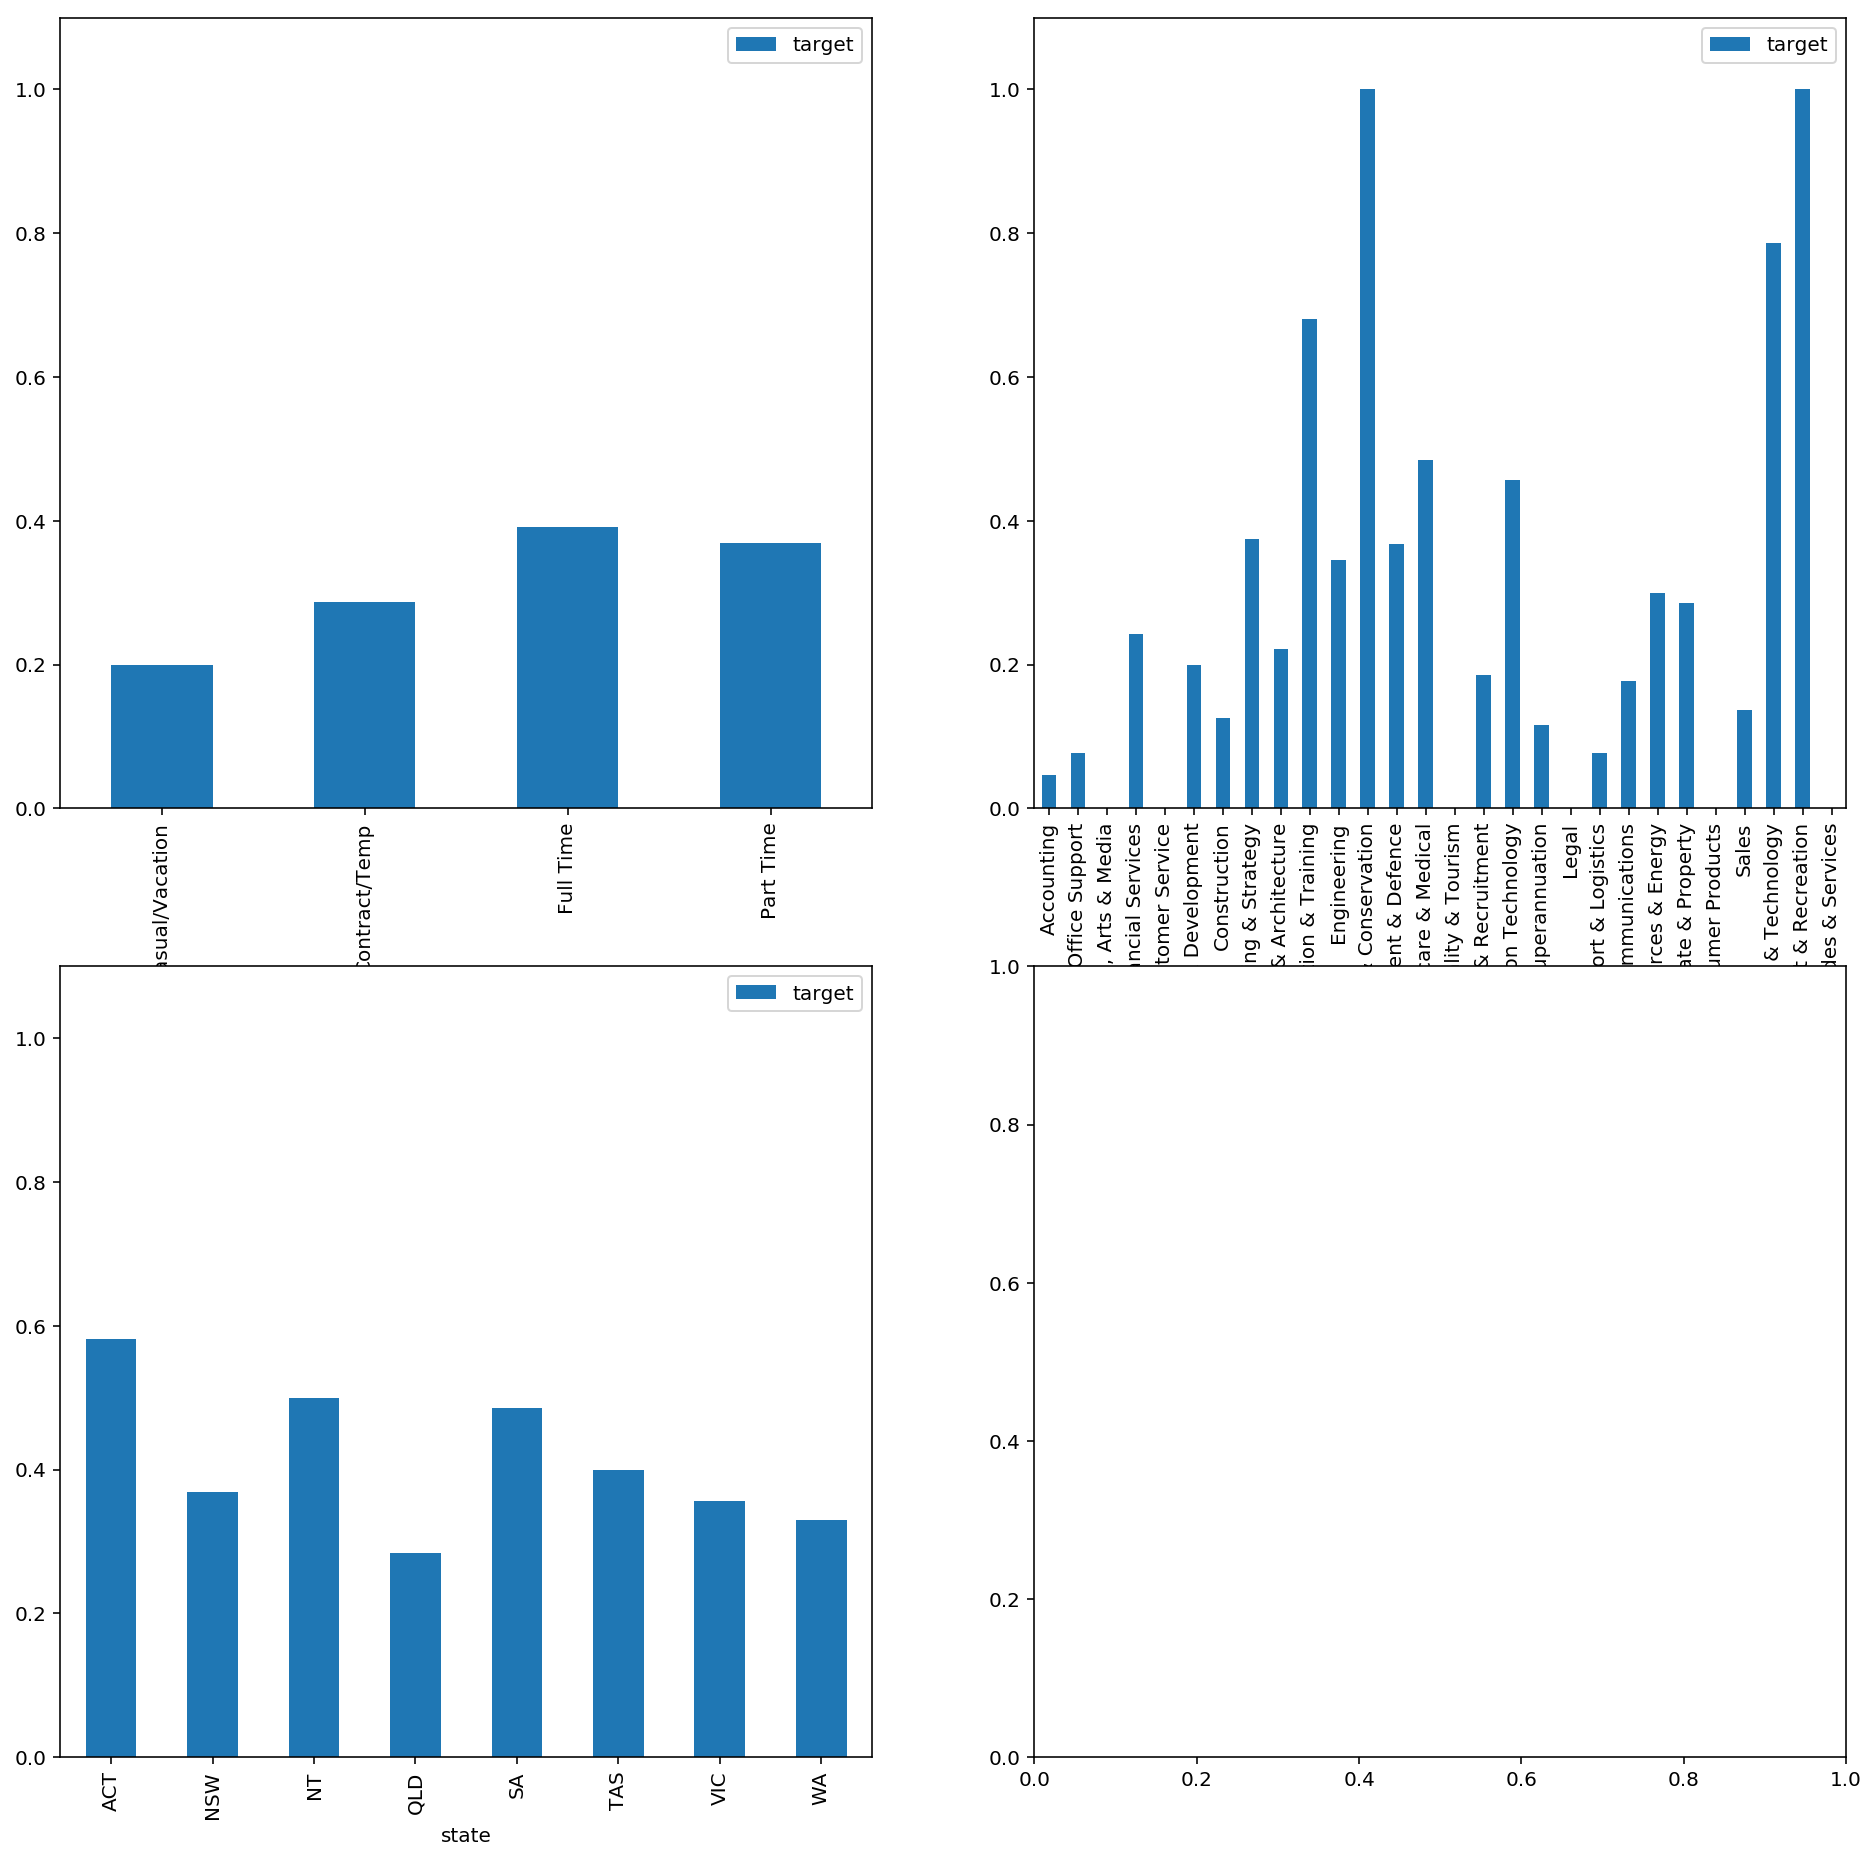

In [36]:
edaCategorical(df[['employment_type', 'field', 'state', 'target']], target = 'target', aggre = 'mean', max_y_axis = 1.1)

### Train Test Split

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
df.head(1)

,url,employment_type,field,description,target,state
0,https://www.seek.com.au/job/37403654?type=stan...,Full Time,Government & Defence,About the business SECMON1 is an innovative ...,0,VIC


In [39]:
X = df[['employment_type', 'field', 'description', 'state']]
y = df['target']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

### Resample the smaller sample

In [41]:
df_train = pd.concat([X_train, y_train], axis = 1)

In [42]:
df_test = pd.concat([X_test, y_test], axis = 1)

#### oversample training set first

In [43]:
df_train_analytic = df_train[df_train['target'] == 0]

In [44]:
df_train_science = df_train[df_train['target'] == 1]

In [45]:
df_train_analytic.shape

(949, 5)

In [46]:
df_train_science.shape

(548, 5)

In [47]:
oversample_amount = df_train_analytic.shape[0] - df_train_science.shape[0]

In [48]:
new_df_train_science = df_train_science.sample(oversample_amount, replace = True)

In [49]:
new_df_train_science.shape

(401, 5)

In [50]:
# recombine into df_train_science
df_train_science = pd.concat([df_train_science, new_df_train_science], axis = 0)

In [51]:
# recombine into df_train
df_train = pd.concat([df_train_science, df_train_analytic], axis = 0)

In [52]:
# reshuffle and reset index
df_train = df_train.sample(frac = 1).reset_index(drop = True)

In [53]:
df_train.target.mean()

0.5

#### oversample test set

In [54]:
df_test_analytic = df_test[df_test['target'] == 0]
df_test_science = df_test[df_test['target'] == 1]

oversample_amount = df_test_analytic.shape[0] - df_test_science.shape[0]

new_df_test_science = df_test_science.sample(oversample_amount, replace = True)

In [55]:
# recombine into df_test_science
df_test_science = pd.concat([df_test_science, new_df_test_science], axis = 0)

In [56]:
# recombine into df_test
df_test = pd.concat([df_test_science, df_test_analytic], axis = 0)

In [57]:
# reshuffle and reset index
df_test = df_test.sample(frac = 1).reset_index(drop = True)

In [58]:
df_test.target.mean()

0.5

#### split back into X_train, X_test, y_train, y_test

In [59]:
X_train = df_train.drop(columns = ['target'])
y_train = df_train['target']

X_test = df_test.drop(columns = ['target'])
y_test = df_test['target']

### Dummifying the categorical variables

In [60]:
X_train.head(1)

,employment_type,field,description,state
0,Full Time,Science & Technology,"Crunch data, uncover insights and create knowl...",VIC


In [61]:
categorical_list = ['employment_type', 'field', 'state']

In [62]:
from cLiML.model_prep import dummify, dummify_test, match_test_to_train_columns

In [63]:
X_train = dummify(X_train, categorical_list)

In [64]:
X_test = dummify_test(X_test, categorical_list)

In [65]:
X_test = match_test_to_train_columns(X_test, X_train)

In [66]:
X_train.shape

(1898, 38)

In [67]:
X_test.shape

(476, 38)

In [68]:
set(X_train.columns.values.tolist()) - set(X_test.columns.values.tolist())

set()

### Stemming the words

In [69]:
def stemSeries(value):
    #from nltk.stem.lancaster import LancasterStemmer
    from nltk.stem import PorterStemmer
    
    # lower case
    value = value.lower()
    
    # clean up 
    value = value.replace('\xa0', ' ')
    value = value.replace(',', ' ')
    value = value.replace(';', ' ')
    value = value.replace('.', ' ')
    value = value.replace('\n', ' ')
    value = value.replace('\r', ' ')
    
    # remove keywords that reveals the target
    value = value.replace('science', '')
    value = value.replace('scientist', '')
    value = value.replace('analytic', '')
    value = value.replace('analyst', '')
    value = value.replace('sciences', '')
    value = value.replace('scientists', '')
    value = value.replace('analytics', '')
    value = value.replace('analysts', '')
    
    
    # split into a list of words
    words = value.split(' ')
    
    # remove empty strings
    stemmed_list = []
    stemmer = PorterStemmer()
    for word in words:
        if word != '':
            try:
                stemmed_list.append(stemmer.stem(word))
            except:
                stemmed_list.append(word)

            
    # join into a stemmed description
    stemmed_des = ' '.join(stemmed_list)
    
    return stemmed_des

In [70]:
descriptions = []
for description in log_progress(X_train.description.values.tolist()):
    description = stemSeries(description)
    descriptions.append(description)

X_train['stemmed_description'] = descriptions

In [71]:
descriptions = []
for description in log_progress(X_test.description.values.tolist()):
    description = stemSeries(description)
    descriptions.append(description)

X_test['stemmed_description'] = descriptions

In [72]:
X_train = X_train.drop(columns = ['description'])
X_test = X_test.drop(columns = ['description'])

In [73]:
X_train.head(3)

,employment_type_Casual/Vacation,employment_type_Contract/Temp,employment_type_Full Time,field_Accounting,field_Administration & Office Support,"field_Advertising, Arts & Media",field_Banking & Financial Services,field_Call Centre & Customer Service,field_Community Services & Development,field_Construction,...,field_Science & Technology,field_Sport & Recreation,state_ACT,state_NSW,state_NT,state_QLD,state_SA,state_TAS,state_VIC,stemmed_description
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,crunch data uncov insight and creat knowledg j...
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mid-level and senior full-stack node js/react ...
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dxc technolog (nyse: dxc) is the world’ lead i...


In [74]:
X_test.head(3)

,employment_type_Casual/Vacation,employment_type_Contract/Temp,employment_type_Full Time,field_Accounting,field_Administration & Office Support,"field_Advertising, Arts & Media",field_Banking & Financial Services,field_Call Centre & Customer Service,field_Community Services & Development,field_Construction,...,field_Science & Technology,field_Sport & Recreation,state_ACT,state_NSW,state_NT,state_QLD,state_SA,state_TAS,state_VIC,stemmed_description
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,a lead australian brand is look for a senior m...
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,the compani our client are look for a except a...
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,let’ talk about me we’r not like other bank me...


### Count Vectorising the description

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

In [76]:
vect = CountVectorizer(stop_words = 'english', ngram_range = (1,2))
X_train_vect = vect.fit_transform(X_train['stemmed_description'])
X_test_vect = vect.transform(X_test['stemmed_description'])

In [77]:
X_column_names = vect.get_feature_names()

In [78]:
X_train_sparse = X_train_vect.toarray()
X_test_sparse = X_test_vect.toarray()

In [79]:
X_train_sparse = pd.DataFrame(X_train_sparse, columns = X_column_names)
X_test_sparse = pd.DataFrame(X_test_sparse, columns = X_column_names)

In [80]:
X_train_sparse.shape

(1898, 136780)

In [81]:
X_train.shape

(1898, 38)

#### filter out the top most popular words

In [82]:
X_train_sparse_count = X_train_sparse.sum()

In [83]:
X_train_sparse_count = pd.DataFrame(X_train_sparse_count, columns = ['Count'])

In [84]:
X_train_sparse_count = X_train_sparse_count[X_train_sparse_count['Count'] > 200]

In [85]:
X_train_sparse_count.sort_values('Count', ascending = False)

,Count
data,11027
experi,8078
work,8007
manag,6449
busi,6280
team,6204
develop,6109
role,5734
thi,5666
skill,4699


In [86]:
selected_columns = X_train_sparse_count.T.columns.values.tolist()

In [87]:
## Only grab the selected columns
X_train_sparse = X_train_sparse[selected_columns]
X_test_sparse = X_test_sparse[selected_columns]

#### Combine the sparse data frame into the main dataframe

In [88]:
X_train = pd.concat([X_train, X_train_sparse], axis = 1)

In [89]:
X_test = pd.concat([X_test, X_test_sparse], axis = 1)

In [90]:
X_train.drop(columns = ['stemmed_description'], inplace = True)
X_test.drop(columns = ['stemmed_description'], inplace = True)

### Saving cleaned and processed data

In [91]:
X_train.to_csv('./readied_data_Q2/X_train.csv')
X_test.to_csv('./readied_data_Q2/X_test.csv')
y_train.to_csv('./readied_data_Q2/y_train.csv')
y_test.to_csv('./readied_data_Q2/y_test.csv')

In [92]:
X_train.shape

(1898, 703)

In [93]:
y_train.shape

(1898,)

In [94]:
X_test.shape

(476, 703)

In [95]:
y_test.shape

(476,)